 - Nick Clifford, Kevin Malloy, Aneesh Sandhir, Devan Visvalingam
 - May 5, 2020
 - SYS 6016

# ML Final: DNN

In [1]:
import math
import numpy as np 
import pandas as pd
import seaborn as sns
import tensorflow as tf 
import matplotlib as mpl
import matplotlib.pyplot as plt 
from sklearn import preprocessing
from tensorflow.keras import layers
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
mpl.rcParams['figure.figsize'] = (14, 12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
datadir = '/Users/nickclifford/Documents/UVA/Spring 2020/SYS 6016 Machine Learning/final_proj/data/'

# 2015-2018 Data

## Load in data

In [3]:
df = pd.read_csv(datadir+'df_all.csv', index_col=0)
# remove unnecessary columns
df = df.drop(['team1..Home.', 'team2..Away.', 'date'], axis=1) 
# sort numerical and categorical columns 
df = df[['season', 'elo_prob1', 'elo_prob2', 'days_rest', 
    'df2.playoff_prob', 'miles', 'born', 'absent', 'home', 'b2b', 'player', 'team', 'rest']]
df = df.query('season <= 2018')

### Class Imbalance

In [4]:
label_props = 100 * df.rest.value_counts() / df.shape[0]
print('Total number of record: {}\n No rest: {:.2f}%\n Rested games: {:.2f}%'.format(
    df.shape[0], label_props[0], label_props[1]))

Total number of record: 9102
 No rest: 99.13%
 Rested games: 0.87%


## Feature Scaling

Make a train/test split before normalizing the data

In [5]:
# convert df to np.array
data = df.values
unscaled_features = data[:, :-1]
labels = data[:, -1].astype(float)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    unscaled_features, labels, test_size=0.25, random_state=30)

Scale quantitative data and convert categorical team/player features as one hot encodings

In [6]:
ohe = preprocessing.OneHotEncoder(sparse=False)

# One hot encode categorical features
cat_train = X_train[:, -2:]
cat_train = ohe.fit_transform(cat_train)
# scale numerical data
X_train = preprocessing.scale(X_train[:, :-2], )
# combine the two
X_train = np.concatenate((X_train, cat_train), axis=1).astype(float)
# handle labels
#y_train = tf.keras.utils.to_categorical(y_train, num_classes=1)


# Do the same for the test data
# One hot encode categorical features
cat_train = X_test[:, -2:]
cat_train = ohe.fit_transform(cat_train)
# scale numerical data
X_test = preprocessing.scale(X_test[:, :-2], )
# combine the two
X_test = np.concatenate((X_test, cat_train), axis=1).astype(float)
# handle labels
#y_test = tf.keras.utils.to_categorical(y_test, num_classes=1)

In [7]:
print('Training labels shape:', y_train.shape)
print('Test labels shape:', y_test.shape)
print('\n')
print('Training features shape:', X_train.shape)
print('Test features shape:', X_test.shape)

Training labels shape: (6826,)
Test labels shape: (2276,)


Training features shape: (6826, 77)
Test features shape: (2276, 77)


## Models

Define function to handle the model building, compiling, and fitting. Include a parameter input for the initial bias. 

In [8]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = tf.keras.Sequential([
      tf.keras.layers.Dense(
          32, activation='relu',
          input_shape=(X_train.shape[-1],)),
        tf.keras.layers.Dense(
          32, activation='relu',
          input_shape=(X_train.shape[-1],)),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
    ])
    
    # Set the optimization method, loss function, and metrics to track
    model.compile(
      optimizer=tf.keras.optimizers.Adam(lr=1e-3),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

Function for visualizing each of performance metrics

In [9]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0,1])
        else:
            plt.ylim([-0.1,1])

        plt.legend()

Function for visualizing a confusion matrix

In [10]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

Function for visualizing ROC curve

In [11]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,85])
    plt.ylim([20,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

### Zero-Bias Model
No initial bias

In [12]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                2496      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,585
Trainable params: 3,585
Non-trainable params: 0
_________________________________________________________________


In [13]:
EPOCHS = 20
BATCH_SIZE = 64

zero_bias_model = make_model()
zero_bias_history = zero_bias_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test), 
    verbose=0)

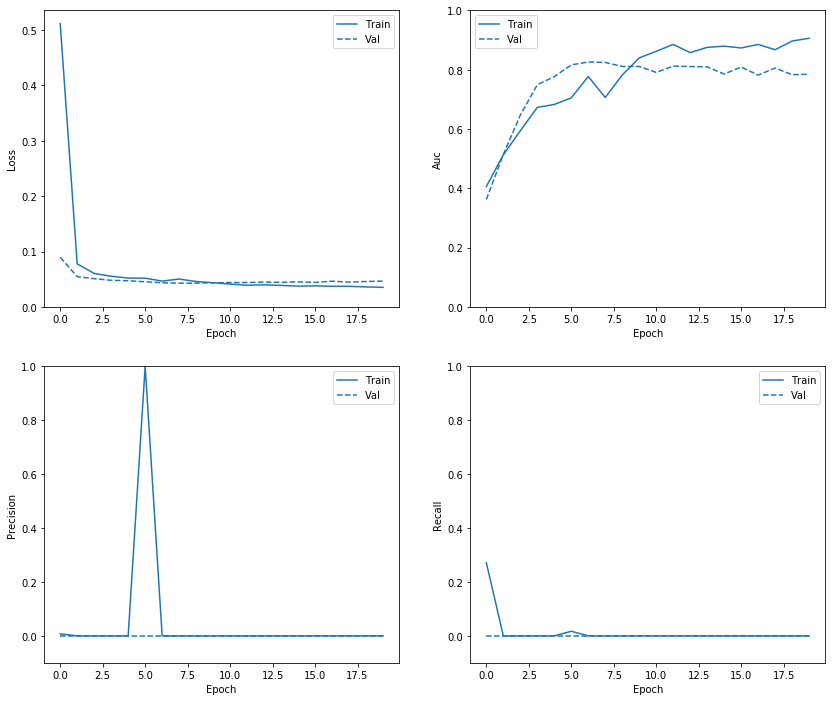

In [14]:
plot_metrics(zero_bias_history)

I don't really care about accuracy here since we can get >99% accuracy by predicting no rest for every observation

### Bias Model

Set the output layer bias to reflect the imbalance of classes. Helps make better initial guesses, which should be seen by comparing epoch loss with zero-bias model. The initial bias is defined as:

$$b_0 = \ln\left(\frac{\text{# positive labels}}{\text{# negative labels}}\right)$$

In [15]:
norest, rest = np.bincount(pd.Series(y_train))
init_bias = np.log( rest / norest )

print('Initial Bias: {:.3f}'.format(init_bias))

Initial Bias: -4.742


In [16]:
EPOCHS = 20
BATCH_SIZE = 64

bias_model = make_model(output_bias=init_bias)
bias_history = bias_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test), 
    verbose=0)

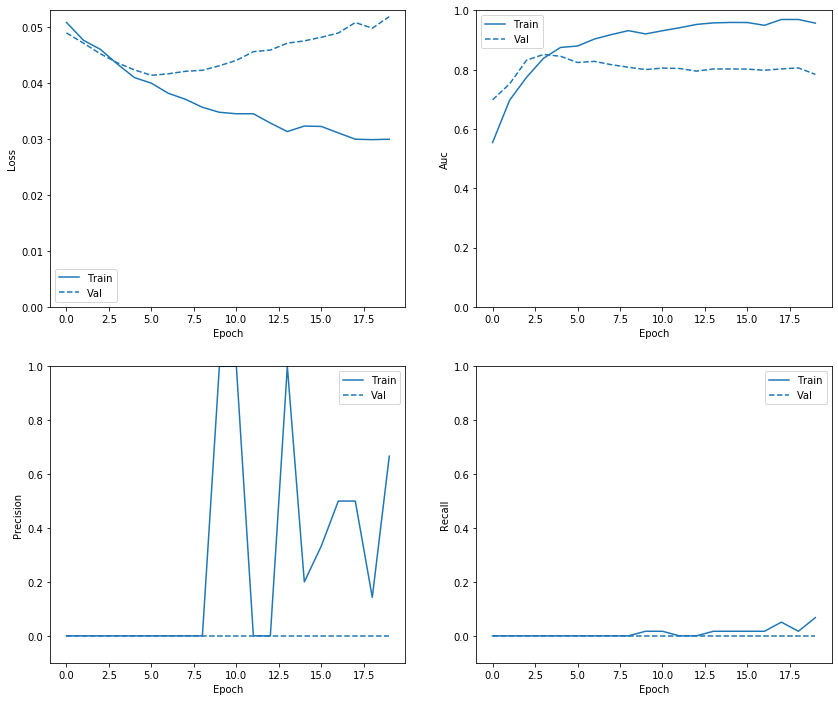

In [17]:
plot_metrics(bias_history)

loss :  0.051858889521713414
tp :  0.0
fp :  0.0
tn :  2256.0
fn :  20.0
accuracy :  0.99121267
precision :  0.0
recall :  0.0
auc :  0.78446364



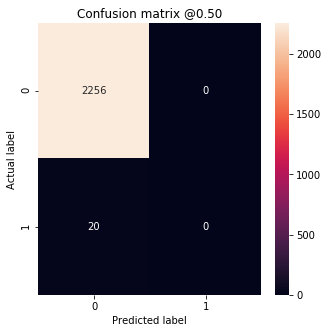

In [18]:
train_predictions_bias = bias_model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_bias = bias_model.predict(X_test, batch_size=BATCH_SIZE)

bias_results = bias_model.evaluate(X_test, y_test,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(bias_model.metrics_names, bias_results):
      print(name, ': ', value)
print()
plot_cm(y_test, test_predictions_bias)

### Weight Scaling

By scaling the class weights, we can try to force the model to pay more attention to the "rested game" examples in the training observations

In [19]:
norest_weight = (1 / norest)*(norest + rest)/2
rest_weight = (1 / rest)*(norest + rest)/2

class_weight = {0: norest_weight, 1: rest_weight}
class_weight

{0: 0.5043593911629969, 1: 57.847457627118644}

In [20]:
EPOCHS = 30
BATCH_SIZE = 64

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

weight_model = make_model()
weight_history = weight_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test), 
    verbose=0,
    class_weight=class_weight,
    callbacks=[early_stopping])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping


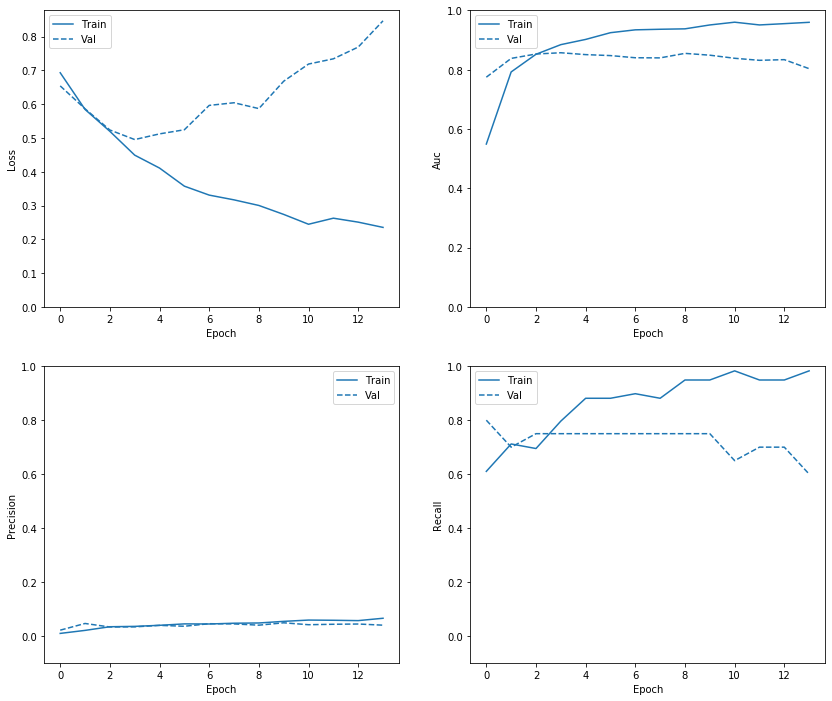

In [21]:
plot_metrics(weight_history)

loss :  0.38838011429682767
tp :  15.0
fp :  435.0
tn :  1821.0
fn :  5.0
accuracy :  0.80667835
precision :  0.033333335
recall :  0.75
auc :  0.8574468



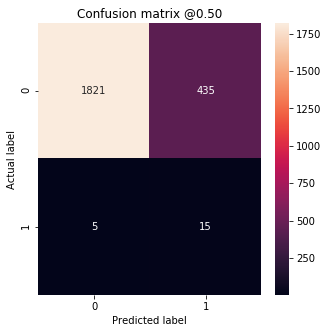

In [22]:
train_predictions_weight = weight_model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_weight = weight_model.predict(X_test, batch_size=BATCH_SIZE)

weight_results = weight_model.evaluate(X_test, y_test,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weight_model.metrics_names, weight_results):
      print(name, ': ', value)
print()
plot_cm(y_test, test_predictions_weight)

### Resampling techniques

In [23]:
bool_train_labels = np.where(y_train == 1, True, False)

# separate training data by class
pos_features = X_train[bool_train_labels]
neg_features = X_train[~bool_train_labels]

pos_labels = y_train[bool_train_labels]
neg_labels = y_train[~bool_train_labels]

In [24]:
ids = np.arange(len(pos_features))
# want to resample positive observations until it is the same size as the negative class
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(6767, 77)

In [25]:
# combine the resampled positive observations with the negative ones
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

# randomly suffle 
order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(13534, 77)

In [26]:
pd.Series(resampled_labels).value_counts()

1.0    6767
0.0    6767
dtype: int64

I won't incorporate a bias metric here since the data is balanced now

In [27]:
EPOCHS = 30
BATCH_SIZE = 64
#resampled_steps_per_epoch = np.ceil(2.0*norest/BATCH_SIZE)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

resampled_model = make_model()

resampled_history = resampled_model.fit(
    resampled_features,
    resampled_labels,
    epochs=EPOCHS,
#    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=(X_test, y_test),
    verbose=0)

Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping


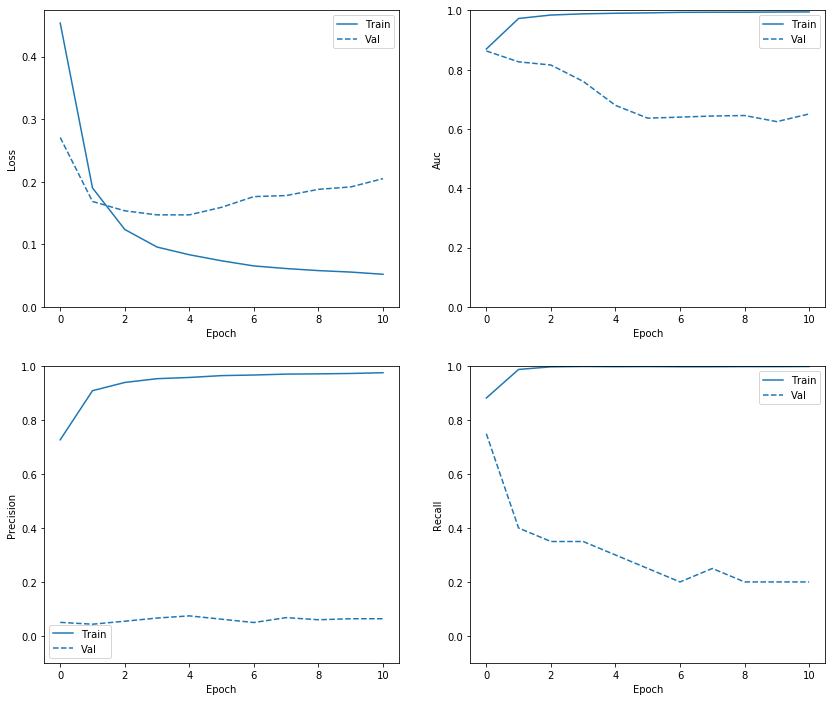

In [28]:
plot_metrics(resampled_history)

loss :  0.2708572477678423
tp :  15.0
fp :  285.0
tn :  1971.0
fn :  5.0
accuracy :  0.8725835
precision :  0.05
recall :  0.75
auc :  0.863464



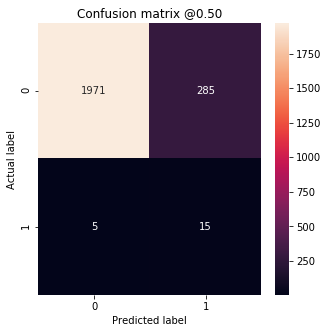

In [29]:
train_predictions_resampled = resampled_model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(X_test, batch_size=BATCH_SIZE)

resampled_results = resampled_model.evaluate(X_test, y_test,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_resampled)

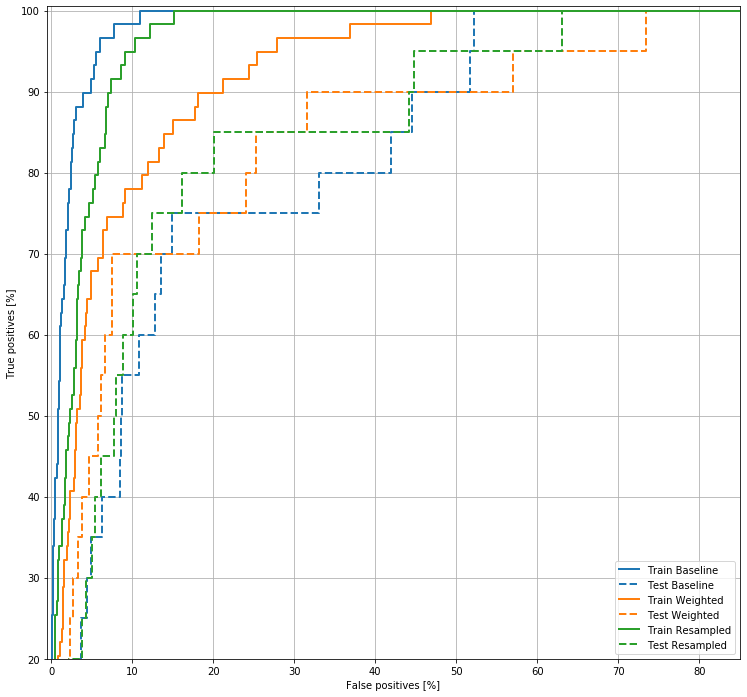

In [30]:
plot_roc("Train Baseline", y_train, train_predictions_bias, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_bias, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_predictions_weight, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weight, color=colors[1], linestyle='--')
plot_roc("Train Resampled", y_train, train_predictions_resampled,  color=colors[2])
plot_roc("Test Resampled", y_test, test_predictions_resampled,  color=colors[2], linestyle='--')
plt.legend(loc='lower right');

# 2015-2020 Data

## Load in all data

In [31]:
df2 = pd.read_csv(datadir + 'df_all2.csv', index_col=0)
# remove unnecessary columns
df2 = df2.drop(['opponent', 'date'], axis=1) 
# remove NaN observations
df2 = df2[pd.notnull(df2.rest)]

df2

,player,season,game,age,df2.playoff_prob,oppo_playoff_prob,days_rest,miles,home,b2b,rest
0,John Wall,2016,1,25.141684,66.0,43.0,10.0,759.0,0.0,0,0.0
1,John Wall,2016,2,25.147159,66.0,34.0,2.0,1067.0,0.0,0,0.0
2,John Wall,2016,3,25.149897,66.0,6.0,1.0,635.0,1.0,1,0.0
3,John Wall,2016,4,25.160849,68.0,98.0,4.0,0.0,1.0,0,0.0
4,John Wall,2016,5,25.166324,68.0,84.0,2.0,394.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
21109,Klay Thompson,2020,59,29.754962,14.0,94.0,2.0,1379.0,1.0,0,1.0
21110,Klay Thompson,2020,60,29.760438,14.0,83.0,2.0,344.0,0.0,0,1.0
21111,Klay Thompson,2020,61,29.765914,3.0,99.9,2.0,344.0,1.0,0,1.0
21112,Klay Thompson,2020,62,29.771389,3.0,14.0,2.0,1917.0,0.0,0,1.0


### Difference in classes

In [32]:
label_props2 = 100 * df2.rest.value_counts() / df2.shape[0]
print('Total number of record: {}\n No rest: {:.2f}%\n Rested games: {:.2f}%'.format(
    df2.shape[0], label_props2[0], label_props2[1]))

Total number of record: 19298
 No rest: 81.16%
 Rested games: 18.84%


## Feature Scaling

Make a train/test split before normalizing the data

In [33]:
# convert df to np.array
data = df2.values
unscaled_features = data[:, :-1]
labels = data[:, -1].astype(float)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    unscaled_features, labels, test_size=0.25, random_state=30)

Scale quantitative data and convert categorical team/player features as one hot encodings

In [34]:
ohe = preprocessing.OneHotEncoder(sparse=False)

# One hot encode categorical features
cat_train = X_train[:, :2]
cat_train = ohe.fit_transform(cat_train)
# scale numerical data
X_train = preprocessing.scale(X_train[:, 1:], )
# combine the two
X_train = np.concatenate((X_train, cat_train), axis=1).astype(float)
# handle labels
#y_train = tf.keras.utils.to_categorical(y_train, num_classes=1)


# Do the same for the test data
# One hot encode categorical features
cat_train = X_test[:, :2]
cat_train = ohe.fit_transform(cat_train)
# scale numerical data
X_test = preprocessing.scale(X_test[:, 1:], )
# combine the two
X_test = np.concatenate((X_test, cat_train), axis=1).astype(float)
# handle labels
#y_test = tf.keras.utils.to_categorical(y_test, num_classes=1)

In [35]:
print('Training labels shape:', y_train.shape)
print('Test labels shape:', y_test.shape)
print('\n')
print('Training features shape:', X_train.shape)
print('Test features shape:', X_test.shape)

Training labels shape: (14473,)
Test labels shape: (4825,)


Training features shape: (14473, 68)
Test features shape: (4825, 68)


## Models

Skip right to initialized bias model

### Bias Model

Set the output layer bias to reflect the imbalance of classes. Helps make better initial guesses, which should be seen by comparing epoch loss with zero-bias model. The initial bias is defined as:

$$b_0 = \ln\left(\frac{\text{# positive labels}}{\text{# negative labels}}\right)$$

In [36]:
norest, rest = np.bincount(pd.Series(y_train))
init_bias = np.log( rest / norest )

print('Initial Bias: {:.3f}'.format(init_bias))

Initial Bias: -1.445


In [37]:
EPOCHS = 30
BATCH_SIZE = 64


bias_model = make_model(output_bias=init_bias)
bias_history = bias_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test), 
    verbose=0,
    callbacks=[early_stopping])

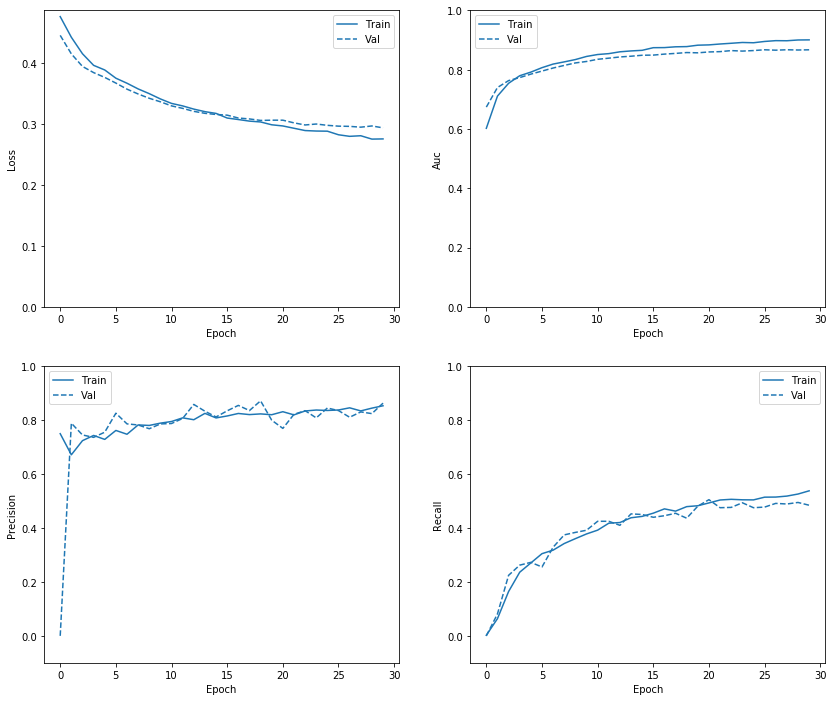

In [38]:
plot_metrics(bias_history)

loss :  0.2935004320014944
tp :  423.0
fp :  67.0
tn :  3885.0
fn :  450.0
accuracy :  0.89284974
precision :  0.86326534
recall :  0.48453608
auc :  0.86739296



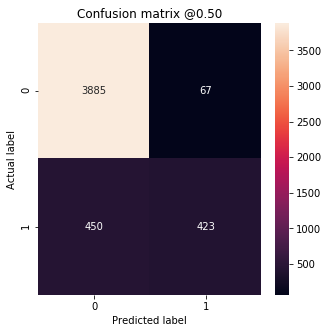

In [39]:
train_predictions_bias = bias_model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_bias = bias_model.predict(X_test, batch_size=BATCH_SIZE)

bias_results = bias_model.evaluate(X_test, y_test,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(bias_model.metrics_names, bias_results):
      print(name, ': ', value)
print()
plot_cm(y_test, test_predictions_bias)

### Weight Scaling

By scaling the class weights, we can try to force the model to pay more attention to the "rested game" examples in the training observations

In [40]:
norest_weight = (1 / norest)*(norest + rest)/2
rest_weight = (1 / rest)*(norest + rest)/2

class_weight = {0: norest_weight, 1: rest_weight}
class_weight

{0: 0.6179233199555972, 1: 2.6200217233888483}

In [41]:
EPOCHS = 100
BATCH_SIZE = 64

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

weight_model = make_model()
weight_history = weight_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test), 
    verbose=0,
    class_weight=class_weight,
    callbacks=[early_stopping])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00075: early stopping


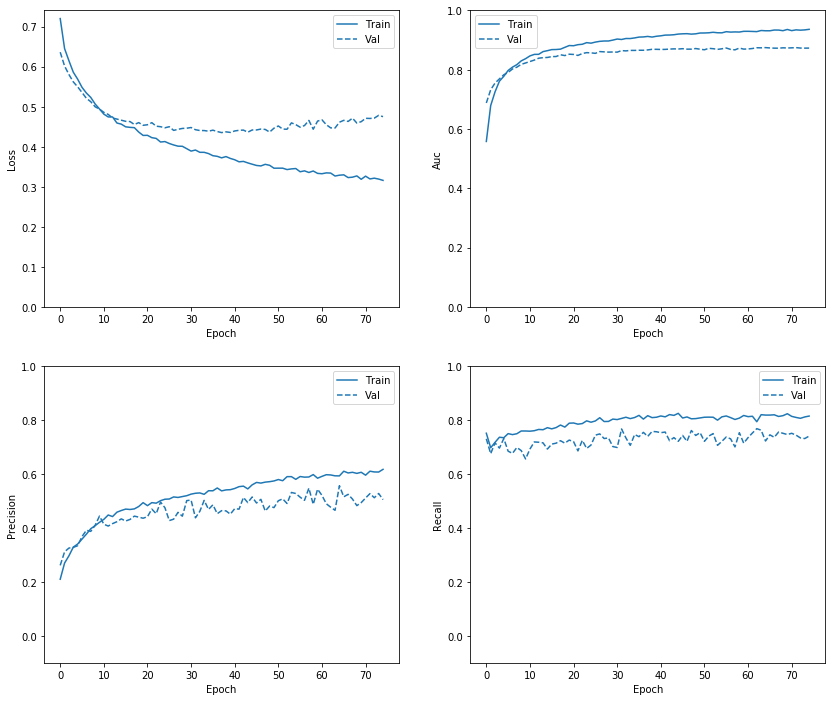

In [42]:
plot_metrics(weight_history)

loss :  0.3688439700887611
tp :  631.0
fp :  502.0
tn :  3450.0
fn :  242.0
accuracy :  0.8458031
precision :  0.5569285
recall :  0.72279495
auc :  0.87478554



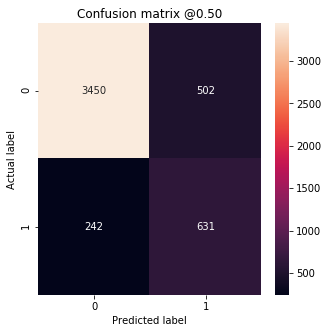

In [43]:
train_predictions_weight = weight_model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_weight = weight_model.predict(X_test, batch_size=BATCH_SIZE)

weight_results = weight_model.evaluate(X_test, y_test,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weight_model.metrics_names, weight_results):
      print(name, ': ', value)
print()
plot_cm(y_test, test_predictions_weight)

### Resampling techniques

In [44]:
bool_train_labels = np.where(y_train == 1, True, False)

# separate training data by class
pos_features = X_train[bool_train_labels]
neg_features = X_train[~bool_train_labels]

pos_labels = y_train[bool_train_labels]
neg_labels = y_train[~bool_train_labels]

In [45]:
ids = np.arange(len(pos_features))
# want to resample positive observations until it is the same size as the negative class
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(11711, 68)

In [46]:
# combine the resampled positive observations with the negative ones
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

# randomly suffle 
order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(23422, 68)

In [47]:
pd.Series(resampled_labels).value_counts()

1.0    11711
0.0    11711
dtype: int64

I won't incorporate a bias metric here since the data is balanced now

In [48]:
EPOCHS = 30
BATCH_SIZE = 64
#resampled_steps_per_epoch = np.ceil(2.0*norest/BATCH_SIZE)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

resampled_model = make_model()

resampled_history = resampled_model.fit(
    resampled_features,
    resampled_labels,
    epochs=EPOCHS,
#    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=(X_test, y_test),
    verbose=0)

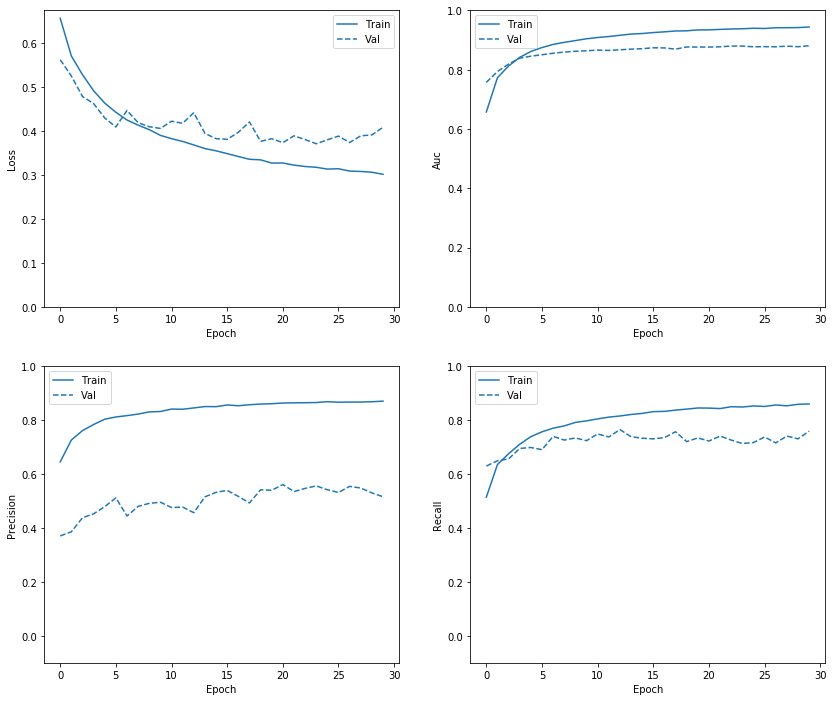

In [49]:
plot_metrics(resampled_history)

loss :  0.4082019054889679
tp :  663.0
fp :  622.0
tn :  3330.0
fn :  210.0
accuracy :  0.8275648
precision :  0.5159533
recall :  0.7594502
auc :  0.8810942



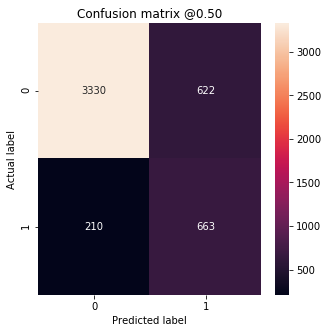

In [50]:
train_predictions_resampled = resampled_model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(X_test, batch_size=BATCH_SIZE)

resampled_results = resampled_model.evaluate(X_test, y_test,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_resampled)

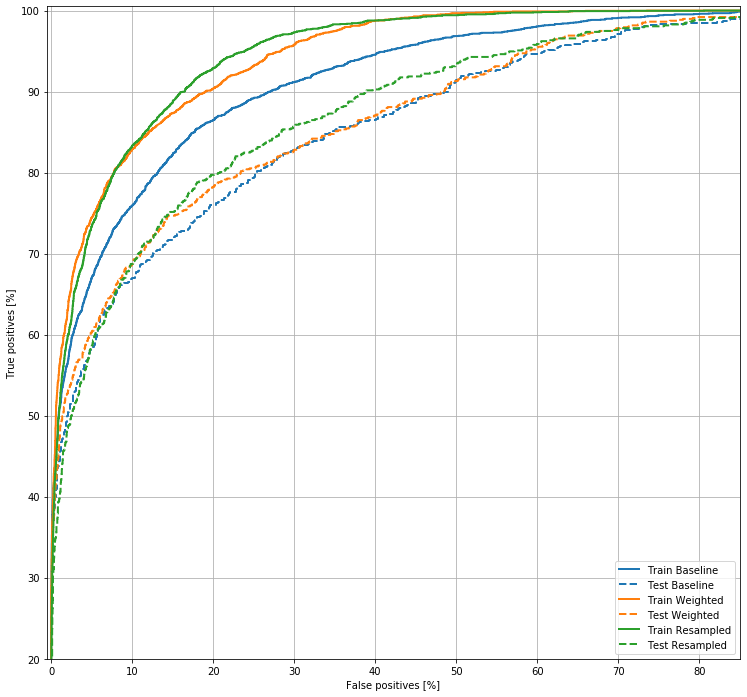

In [51]:
plot_roc("Train Baseline", y_train, train_predictions_bias, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_bias, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_predictions_weight, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weight, color=colors[1], linestyle='--')
plot_roc("Train Resampled", y_train, train_predictions_resampled,  color=colors[2])
plot_roc("Test Resampled", y_test, test_predictions_resampled,  color=colors[2], linestyle='--')
plt.legend(loc='lower right');

# Methods to overcome imbalanced data
- Data:
 - undersample majority class -- might lead to overfitting
 - intelligent undersample majority class -- Near-Miss/K-NN algs. to remove majority samples based on their distance from minority samples. **Zhang J, Mani I. KNN approach to unbalanced data distributions: a case study involving information extraction. In: Proceedings of the ICML’2003 workshop on learning from imbalanced datasets. 2003.**
 - oversample minority class -- increased training time, overfitting
 - informed oversample minority class -- Synthetic Minority Over-sampling Technique (SMOTE), makes artificial minority classes. **Han H, Wang W-Y, Mao B-H. Borderline-smote: a new over-sampling method in imbalanced data sets learning. In: Huang D-S, Zhang X-P, Huang G-B, editors. Adv Intell Comput. Berlin: Springer; 2005. p. 878–87.**
 - cluster-based over-samplig -- cluster classes using k-means, then over-sample to each cluster. Improves within-class and between-class imbalance **(Jo T, Japkowicz N. Class imbalances versus small disjuncts. SIGKDD Explor Newsl. 2004;6(1):40–9. https://doi.org/10.1145/1007730.1007737.)**
 - avoid ohe -- use categorical feature embedding to create more meaningful representations rather than traditional one hot encoding

- Algorithm:
 - new loss function 
 - cost-sensitive learning -- increasing the cost of the minority group is equivalent to increase its importance, decreasing the likelihood that the learner will incorrectly classify instances from it. 
 - threshold moving -- based on each classes estimated prior probability, reduce likelihood of misclassifying examples from minority group

(Johnson, J.M., Khoshgoftaar, T.M. Survey on deep learning with class imbalance. J Big Data 6, 27 (2019). https://doi.org/10.1186/s40537-019-0192-5)